# Práctica RNN
## Hugo Fole Abellás y José Romero Conde

------

En esta práctica deberás desarrollar un modelo que sea capaz de predecir el precio del dólar en euros con
6h de adelanto. Para ello, contarás con el fichero de datos UDC_EUR.json, disponible en el canal de Teams de
la asignatura.

La idea es hacer un modelo que te permita decidir cuándo comprar y cuándo vender dólares, para que puedas
operar de la siguiente manera:
 - Si el modelo predice que el dólar bajará: vendo un dólar ahora y lo compro más barato dentro de 6h. La diferencia entre el precio de venta y el de compra es mi ganancia.
 - Si el modelo predice que el dólar subirá: compro un dólar ahora y lo vendo más caro dentro de 6h. La diferencia entre el precio de compra y el de venta es mi ganancia.
 - Puedes suministrarle al modelo los datos de entrada que estimes para cada predicción, siempre
respetando que ninguno esté a menos de 6h del que intentas predecir.

Debes respetar las siguientes restricciones:

 - No se deben utilizar datos posteriores a 31/08/2022 23:59:59 para entrenamiento. Los datos desde
01/09/2022 00:00:00 en adelante se podrán utilizar como conjunto de test.
 - La predicción se deberá hacer a 6h vista, es decir, se deberá predecir el valor de salida 6 horas
después del dato más reciente que se le proporcione al modelo. Se deberán predecir dos valores distintos:
      - Valor de la variable "precio fin".
      - Valor binario que indicará si "precio fin"6h después será mayor o menor que en el dato más
reciente proporcionado a la entrada.

----

## _Librerías_

In [1]:
import pandas as pd # siguiendo la convención universal
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import os
import datetime
from tensorflow.keras import layers, models,metrics, losses,optimizers
from tensorflow import keras
import seaborn as sns

## 1. Carga y examina los datos

### 1.1. Carga los datos con Pandas y haz un examen preliminar de los mismos. Descarta aquellos que sean erróneos.

In [2]:
if "USD_EUR.json" in os.listdir():
    df = pd.read_json("USD_EUR.json") # usando df para seguir la convención

In [3]:
df.describe() # les echamos un ojo

,timestamp inicial,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,timestamp final,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros
count,24970,24970.000000,24970.000000,24970.000000,24970.000000,2.497000e+04,24970,2.497000e+04,24970.000000,2.497000e+04,2.497000e+04
mean,2021-06-07 09:52:59.014818048,1.126497,1.127797,1.125329,1.126459,1.588138e+06,2021-06-07 10:52:58.645466880,1.831407e+06,3249.635603,7.412968e+05,8.552054e+05
min,2020-01-03 08:00:00,0.953600,0.955400,0.953500,0.953600,0.000000e+00,2020-01-03 08:59:59.999000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,2020-09-19 22:15:00,1.080000,1.082000,1.078000,1.080000,7.440733e+04,2020-09-19 23:14:59.999000064,8.558465e+04,298.000000,3.189642e+04,3.638405e+04
50%,2021-06-07 13:30:00,1.133000,1.134000,1.132000,1.133000,7.911794e+05,2021-06-07 14:29:59.999000064,8.722955e+05,2046.000000,3.359175e+05,3.709915e+05
75%,2022-02-22 21:45:00,1.178800,1.179900,1.177700,1.178700,2.069755e+06,2022-02-22 22:44:59.999000064,2.302447e+06,4215.000000,9.509889e+05,1.063618e+06
max,2022-11-10 00:00:00,1.309800,4.950000,1.269500,1.309800,4.694843e+07,2022-11-10 00:59:59.999000,5.784383e+07,53917.000000,2.354437e+07,2.905002e+07
std,NaN,0.066949,0.071274,0.066925,0.066935,2.435379e+06,NaN,2.898230e+06,4291.602485,1.189478e+06,1.413589e+06


Vemos en el resumen superior que hay un valor muy alto en `precio mas alto`, constrastamos esta creencia ploteando.

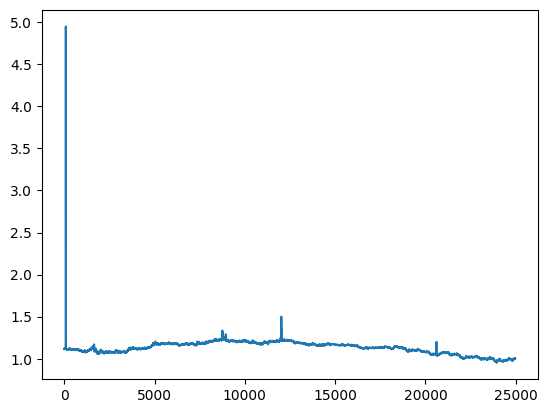

In [4]:
plt.plot(df[["precio mas alto"]]);

Filtramos (solo las columnas numéricas) los valores que estén alejados a más de 3 sigmas de la media. Y vemos el resultado en que el plot anterior ahora es más correcto. (De todas formas, el plot solo muestra de una columna y se filtra en todas menos dos.)

In [5]:
columnasFiltrar = ['precio inicio', 'precio mas alto', 'precio mas bajo', 'precio fin', 'volumen', 'volumen en cuotas', 'volumen en cuotas', 'numero de compras', 'volumen de dolares', 'volumen de euros']

df = df[(np.abs(stats.zscore(df[columnasFiltrar])) < 1.8).all(axis=1)]

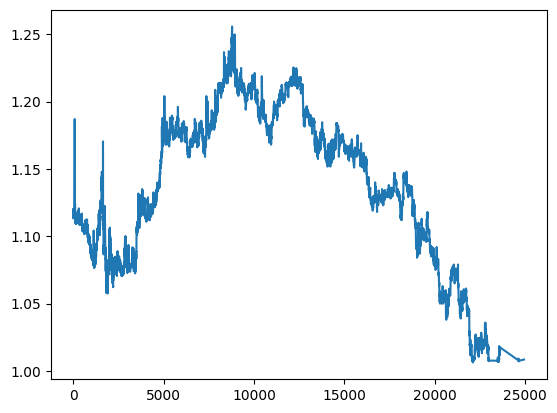

In [6]:
plt.plot(df[["precio mas alto"]]);

Ver como cambian los datos con el tiempo.

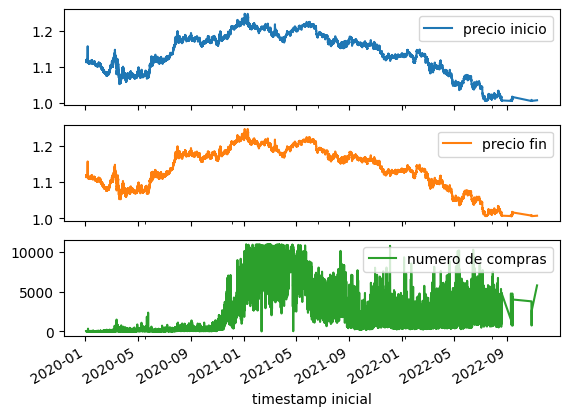

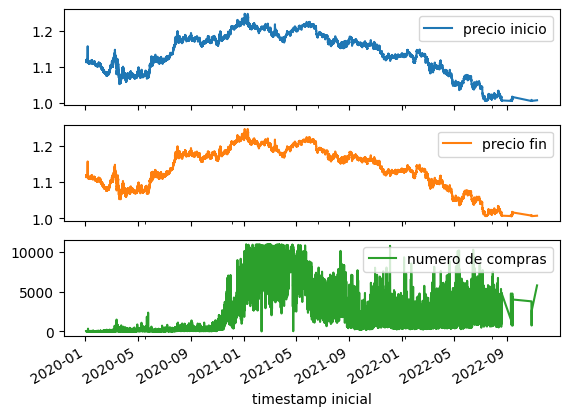

In [7]:
plot_cols = ['precio inicio', 'precio fin', 'numero de compras']
plot_features = df[plot_cols]
plot_features.index = df['timestamp inicial']
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:]
plot_features.index = df['timestamp inicial'][:]
_ = plot_features.plot(subplots=True)

In [8]:
df.head()

,timestamp inicial,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,timestamp final,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros
0,2020-01-03 08:00:00,1.1154,1.1200,1.1154,1.1182,37309.48,2020-01-03 08:59:59.999,41775.464275,31,20419.46,22858.822356
1,2020-01-03 09:00:00,1.1182,1.1182,1.1151,1.1151,2132.61,2020-01-03 09:59:59.999,2384.431292,5,2036.69,2277.401075
2,2020-01-03 10:00:00,1.1151,1.1172,1.1151,1.1151,1950.83,2020-01-03 10:59:59.999,2175.391533,4,10.00,11.172000
3,2020-01-03 11:00:00,1.1136,1.1151,1.1136,1.1141,310.53,2020-01-03 11:59:59.999,346.107438,4,232.00,258.656430
4,2020-01-03 12:00:00,1.1126,1.1133,1.1126,1.1133,394.52,2020-01-03 12:59:59.999,439.130428,3,0.00,0.000000


Comprobaremos que los datos están recogidos de manera correcta, es decir, cada hora. Para ello iteraremos en un bucle que recorrerá la variable `timestamp inicial` para que compruebe si se están recogiendo los datos correctamente.

[85, 880, 1129, 1458, 2697, 4231, 7952, 8463, 8515, 8542, 8751, 8753, 8757, 8758, 8812, 8815, 8830, 8833, 8834, 8888, 8899, 8908, 8913, 8988, 9006, 9118, 9121, 9137, 9138, 9141, 9146, 9147, 9280, 9303, 9306, 9308, 9309, 9330, 9355, 9356, 9367, 9386, 9392, 9395, 9414, 9418, 9427, 9428, 9431, 9440, 9456, 9464, 9466, 9467, 9473, 9474, 9475, 9482, 9488, 9494, 9495, 9498, 9500, 9507, 9514, 9526, 9533, 9537, 9538, 9545, 9555, 9564, 9572, 9576, 9577, 9582, 9590, 9591, 9592, 9601, 9607, 9616, 9617, 9626, 9627, 9628, 9633, 9634, 9636, 9646, 9654, 9662, 9668, 9672, 9682, 9697, 9700, 9701, 9715, 9716, 9717, 9719, 9731, 9734, 9746, 9757, 9809, 9811, 9819, 9828, 9838, 9845, 9851, 9852, 9864, 9866, 9867, 9875, 9878, 9884, 9894, 9895, 9904, 9915, 9925, 9926, 9927, 9950, 9960, 9967, 9968, 9978, 9980, 9987, 9998, 9999, 10018, 10021, 10047, 10059, 10063, 10064, 10077, 10086, 10095, 10101, 10105, 10106, 10107, 10108, 10116, 10129, 10134, 10140, 10147, 10154, 10163, 10170, 10171, 10183, 10192, 10201, 1020

(array([410.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([   7200.,  379800.,  752400., 1125000., 1497600., 1870200.,
        2242800., 2615400., 2988000., 3360600., 3733200.]),
 <BarContainer object of 10 artists>)

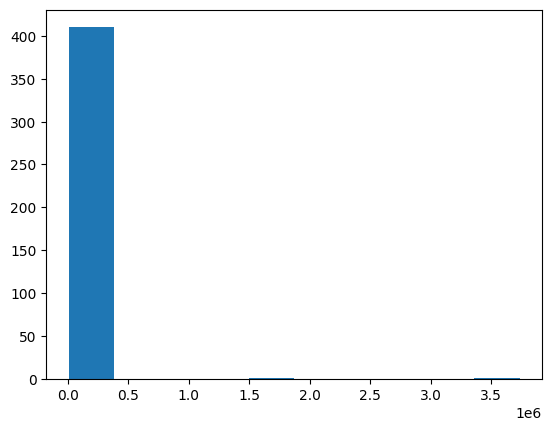

In [9]:
hora = pd.Timedelta(seconds=3600)
fechas = df[:-1]['timestamp inicial']
fechassegundos = pd.to_datetime(fechas, format='%d.%m.%Y %H:%M:%S')
instancias = []
diferencias = []
cadahora = True

for i in range(len(fechassegundos) - 1):  # Hasta el penúltimo índice
    if (fechassegundos.iloc[i + 1] - fechassegundos.iloc[i]) != hora:
        instancias.append(i)
        cadahora = False
        diferencias.append((fechassegundos.iloc[i + 1] - fechassegundos.iloc[i]).total_seconds())

print(instancias, diferencias, cadahora, sep = '\n\n')

plt.hist(diferencias)

Sabemos que en un 1% de las veces que se recogen datos, se rompe la linealidad de la recogida de datos.

In [10]:
len(instancias)/len(df)

0.01963307124136288

Comprobamos que lo que acabamos de averiguar es cierto. Según la prueba, entre la instancia nº 85 y la 86 transcurren dos horas, es decir, hay una hora en la que o bien no se recogieron datos, o bien se perdieron.

In [11]:
print(df[85:87]['timestamp inicial'])

85   2020-01-06 21:00:00
87   2020-01-06 23:00:00
Name: timestamp inicial, dtype: datetime64[ns]


### 1.2. Haz la partición entre conjunto de entrenamiento y conjunto de test.

In [12]:
instanteSeparacion = pd.to_datetime("31/08/2022 23:59:59", dayfirst=True)
dfEntrenamiento = df[df['timestamp inicial'] <= instanteSeparacion]
dfTest = df[df['timestamp inicial'] > instanteSeparacion]

In [13]:
print(dfEntrenamiento.head())

    timestamp inicial  precio inicio  precio mas alto  precio mas bajo  \
0 2020-01-03 08:00:00         1.1154           1.1200           1.1154   
1 2020-01-03 09:00:00         1.1182           1.1182           1.1151   
2 2020-01-03 10:00:00         1.1151           1.1172           1.1151   
3 2020-01-03 11:00:00         1.1136           1.1151           1.1136   
4 2020-01-03 12:00:00         1.1126           1.1133           1.1126   

   precio fin   volumen         timestamp final  volumen en cuotas  \
0      1.1182  37309.48 2020-01-03 08:59:59.999       41775.464275   
1      1.1151   2132.61 2020-01-03 09:59:59.999        2384.431292   
2      1.1151   1950.83 2020-01-03 10:59:59.999        2175.391533   
3      1.1141    310.53 2020-01-03 11:59:59.999         346.107438   
4      1.1133    394.52 2020-01-03 12:59:59.999         439.130428   

   numero de compras  volumen de dolares  volumen de euros  
0                 31            20419.46      22858.822356  
1           

----

## 2. Preprocesado

### 2.1. Representa las variables en un formato que facilite el aprendizaje. Para ello estandariza aquellas que lo necesiten y transforma las fechas a un formato adecuado.

Comenzaremos transformando las fechas a un formato que nuestro modelo pueda entender.Utilizaremos un método simple para convertirlo en una señal utilizable es usar el [seno] y el [coseno] para convertir la hora en señales claras de "Hora del día" y "Hora del año". Hay que operar de tal manera que:

1. $\cos(hora~0) = \cos(hora~24)$ y $\sin(hora~0) = \sin(hora~24)$ en la hora del día.
1. $\cos(1~enero) \approx \cos(31~diciembre)$ y $\sin(1~enero) \approx \sin(31~diciembre)$ en la hora anual.

La variable a tranformar será:
- `timestamp inicial` : representa el punto en el tiempo en el que se empiezan a recoger datos.

Además, eliminaremos la variable `timestamp final` ya que consideramos que no aporta una información relevante a la hora de entrenar el modelo.


In [14]:
def ajustar_fechas(dataset):
    #Sacamos los valores de las fechas (inicial y final)
    date_time_inicial = pd.to_datetime(dataset.pop('timestamp inicial'), format='%d.%m.%Y %H:%M:%S')
    # Los pasamos a segundos
    timestamp_s_inicial = date_time_inicial.map(pd.Timestamp.timestamp)
    #Segundos en un dia y un año
    day = 24 * 60 * 60
    year = 365 * day

    # TODO: Extrae, para cada fecha, el seno y el coseno, y añádelos al dataframe
    dataset['Dia sin inic'] = np.sin(2 * np.pi * (timestamp_s_inicial % day) / day)
    dataset['Dia cos inic'] = np.cos(2 * np.pi * (timestamp_s_inicial % day) / day)
    dataset['Anho sin inic'] = np.sin(2 * np.pi * (timestamp_s_inicial % year) / year)
    dataset['Anho cos inic'] = np.cos(2 * np.pi * (timestamp_s_inicial % year) / year)

    dataset.pop('timestamp final')

    return dataset

In [15]:
dfEntrenamiento = ajustar_fechas(dfEntrenamiento)
dfTest = ajustar_fechas(dfTest)

/var/folders/v6/ybkmv61n1fgd69w84cn8vtqc0000gn/T/ipykernel_39176/514935241.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Dia sin inic'] = np.sin(2 * np.pi * (timestamp_s_inicial % day) / day)
/var/folders/v6/ybkmv61n1fgd69w84cn8vtqc0000gn/T/ipykernel_39176/514935241.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Dia cos inic'] = np.cos(2 * np.pi * (timestamp_s_inicial % day) / day)
/var/folders/v6/ybkmv61n1fgd69w84cn8vtqc0000gn/T/ipykernel_39176/514935241.py:13: SettingWithCop

In [16]:
print(dfEntrenamiento.head())

   precio inicio  precio mas alto  precio mas bajo  precio fin   volumen  \
0         1.1154           1.1200           1.1154      1.1182  37309.48   
1         1.1182           1.1182           1.1151      1.1151   2132.61   
2         1.1151           1.1172           1.1151      1.1151   1950.83   
3         1.1136           1.1151           1.1136      1.1141    310.53   
4         1.1126           1.1133           1.1126      1.1133    394.52   

   volumen en cuotas  numero de compras  volumen de dolares  volumen de euros  \
0       41775.464275                 31            20419.46      22858.822356   
1        2384.431292                  5             2036.69       2277.401075   
2        2175.391533                  4               10.00         11.172000   
3         346.107438                  4              232.00        258.656430   
4         439.130428                  3                0.00          0.000000   

   Dia sin inic  Dia cos inic  Anho sin inic  Anho cos i

In [17]:
columnasNormalizar = ['volumen', 'volumen en cuotas','numero de compras', 'volumen de dolares', 'volumen de euros']
datasets = [dfEntrenamiento, dfTest]
for df in datasets:
    for col in columnasNormalizar:
        df[col] = (df[col] - df[col].mean()) / df[col].std()


In [18]:
print(dfEntrenamiento.head())

   precio inicio  precio mas alto  precio mas bajo  precio fin   volumen  \
0         1.1154           1.1200           1.1154      1.1182 -0.820631   
1         1.1182           1.1182           1.1151      1.1151 -0.849449   
2         1.1151           1.1172           1.1151      1.1151 -0.849598   
3         1.1136           1.1151           1.1136      1.1141 -0.850942   
4         1.1126           1.1133           1.1126      1.1133 -0.850873   

   volumen en cuotas  numero de compras  volumen de dolares  volumen de euros  \
0          -0.811221          -0.932360           -0.777811         -0.769815   
1          -0.839048          -0.943217           -0.809300         -0.800216   
2          -0.839196          -0.943634           -0.812772         -0.803564   
3          -0.840488          -0.943634           -0.812392         -0.803198   
4          -0.840423          -0.944052           -0.812789         -0.803580   

   Dia sin inic  Dia cos inic  Anho sin inic  Anho cos i

Ver como se reparten los valores una vez normalizados.

/var/folders/v6/ybkmv61n1fgd69w84cn8vtqc0000gn/T/ipykernel_39176/3962566233.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(dfEntrenamiento.keys(), rotation=90)


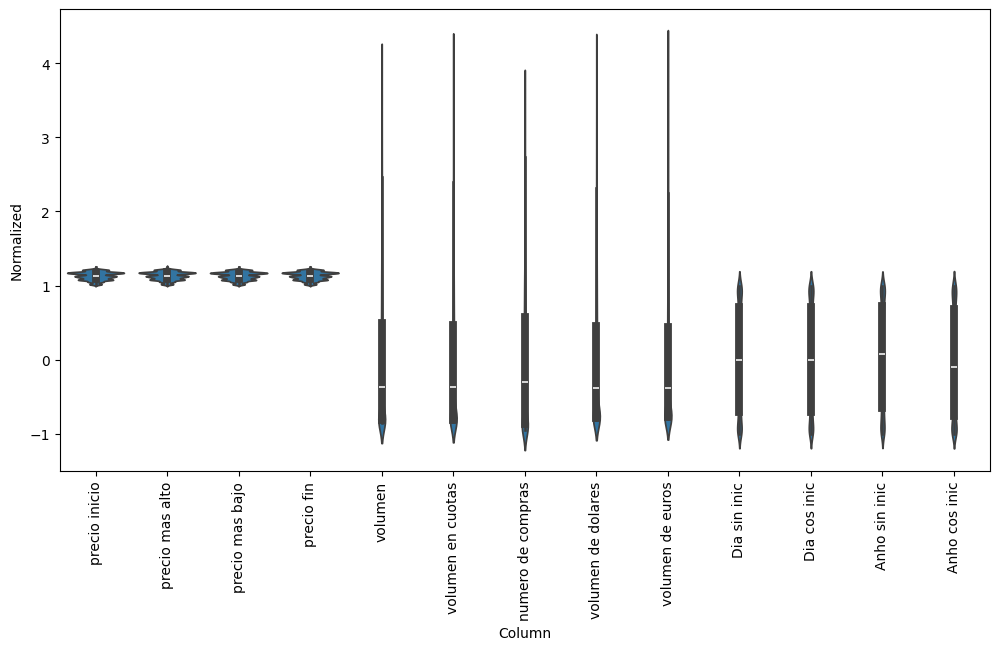

In [19]:
df_std = dfEntrenamiento.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dfEntrenamiento.keys(), rotation=90)

Añadiremos una variable que usaremos como target la cual indicará qué acción se tiene que hacer a 6 horas vista.
- `Comprar` = 1 : esto indica que el precio del dólar en 6 horas será mayor que el precio actual.
- `Vender` = 0 : esto indica que el precio del dólar en 6 horas será menor que el precio actual.


# PEPE LEE ESTO
Lo que hago aqui es pasar el precio inicio de 6 horas adelante a la instancia actual con lo de shift -6, y despues en base a al precio inicial y al precio en 6h saco si vender o comprar.

De esta manera, tenemos  "el futuro en el presente", por lo que no hara falta cambiar el offset y podremos dejarlo a 0.

Cambie la funcion de sliding_windows para que devuelva 3 valores de ventanitas:

1. `Entradas` - caractteristicas (lo gordo)
2. `Salidas 1` - valores de precio inicial en un futuro.
3. `Salidas 2` - valores binarios de 1 comprar o 0 vender.

In [20]:
dfEntrenamiento['precio en 6h'] = dfEntrenamiento['precio inicio'].shift(-6)

dfEntrenamiento['accion'] = dfEntrenamiento.apply(lambda row: 1 if row['precio en 6h'] > row['precio inicio'] else 0, axis=1)


In [21]:
dfTest['precio en 6h'] = dfTest['precio inicio'].shift(-6)

dfTest['accion'] = dfTest.apply(lambda row: 1 if row['precio en 6h'] > row['precio inicio'] else 0, axis=1)

In [22]:
print(dfEntrenamiento[-10:])

       precio inicio  precio mas alto  precio mas bajo  precio fin   volumen  \
22976         1.0086           1.0092           1.0083      1.0085  0.119797   
22977         1.0084           1.0085           1.0065      1.0069  0.164504   
22978         1.0070           1.0073           1.0065      1.0069 -0.149444   
22979         1.0069           1.0081           1.0067      1.0081 -0.386041   
22980         1.0081           1.0081           1.0077      1.0078 -0.401740   
22981         1.0078           1.0078           1.0070      1.0073 -0.284861   
22982         1.0072           1.0078           1.0068      1.0078 -0.122259   
22983         1.0078           1.0084           1.0065      1.0066  1.573304   
22984         1.0065           1.0081           1.0061      1.0076  1.290953   
22985         1.0076           1.0077           1.0067      1.0075  1.822359   

       volumen en cuotas  numero de compras  volumen de dolares  \
22976           0.003740           0.189227         

Tras cambiar las variables a 6 horas menos, las ultimas 6 variables tendran como nulos los valores de `precio en 6h` y `accion` ya que no tienen datos que puedan usar. Por ello, eliminaremos las últimas 6 isntancias para no tener datos nulos.

In [23]:
dfEntrenamiento = dfEntrenamiento[0:-6]

In [24]:
dfTest = dfTest[0:-6]

In [25]:
dfEntrenamiento[-6:]

,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros,Dia sin inic,Dia cos inic,Anho sin inic,Anho cos inic,precio en 6h,accion
22974,1.0089,1.0097,1.0088,1.0090,-0.045742,-0.139906,-0.041688,-0.055410,-0.144574,-0.707107,0.707107,-0.862054,-0.506817,1.0081,0
22975,1.0090,1.0093,1.0086,1.0087,-0.354599,-0.408626,-0.273855,-0.260615,-0.323087,-0.500000,0.866025,-0.862417,-0.506199,1.0078,0
22976,1.0086,1.0092,1.0083,1.0085,0.119797,0.003740,0.189227,-0.188495,-0.260606,-0.258819,0.965926,-0.862780,-0.505580,1.0072,0
22977,1.0084,1.0085,1.0065,1.0069,0.164504,0.041510,-0.090961,0.054199,-0.050535,0.000000,1.000000,-0.863142,-0.504961,1.0078,0
22978,1.0070,1.0073,1.0065,1.0069,-0.149444,-0.231407,-0.258823,0.039770,-0.063334,0.258819,0.965926,-0.863504,-0.504342,1.0065,0
22979,1.0069,1.0081,1.0067,1.0081,-0.386041,-0.436695,-0.496001,-0.079740,-0.166835,0.500000,0.866025,-0.863866,-0.503722,1.0076,1


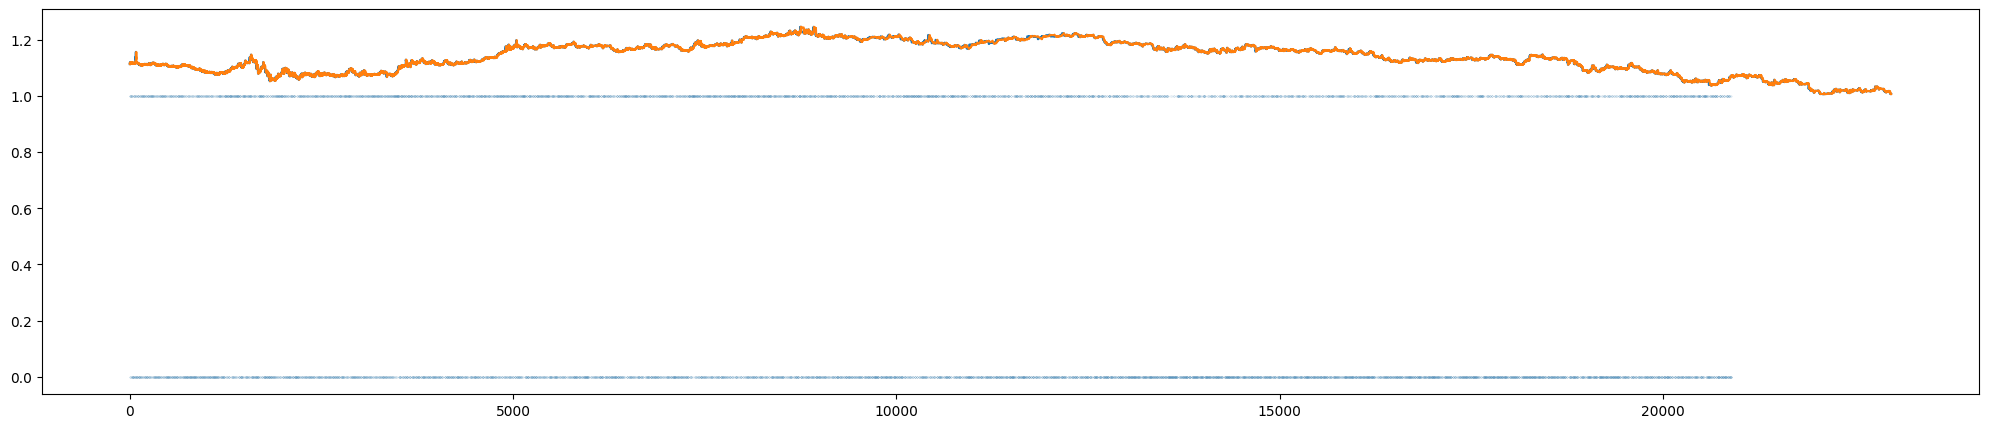

In [26]:
plt.figure(figsize=(25,5))
plt.plot(dfEntrenamiento['precio en 6h'])
plt.plot(dfEntrenamiento['precio inicio'])
plt.scatter(range(len(dfEntrenamiento['accion'])),dfEntrenamiento['accion'],s=.001)

### 2.2. Transforma los conjuntos de entrenamiento y test a NumPy.

In [27]:
dfEntrenamientoNP = dfEntrenamiento.to_numpy()
dfTestNP = dfTest.to_numpy()

### 2.3. Utiliza la función sliding_window del Lab11 para ventanear la serie temporal para obtener un lote de muchos pares (vector de entrada, etiqueta) para entrenamiento y otro lote para test:
- Haz que el tamaño de ventana sea configurable para poder probar varias alternativas.
- Revisa la continuidad temporal de la serie para que las ventanas representen siempre el mismo
periodo de tiempo. Descarta las ventanas incorrectas.

Dado que realizaremos un problema de clasificación de dos salidas, adaptaremos la función `sliding_window` que se nos aportó en el **laboratorio 11** de manera que nos haga las ventanas para dos salidas.

Sabiendo que en los datasets las últimas dos columnas son las que hemos asignado como targets a 6 horas vista.

In [28]:
def sliding_window(data, labels1, labels2, input_width, label_width=1, offset=0):
    x = []
    y = []
    z = []
    # Corrección en el rango del bucle
    for i in range(len(data) - input_width - label_width - offset + 1):
        # Seleccionar la ventana de entrada y etiquetas
        _x = data[i:i + input_width]
        _y = labels1[i + input_width + offset:i + input_width + offset + label_width]
        _z = labels2[i + input_width + offset:i + input_width + offset + label_width]
        x.append(_x)
        y.append(_y)
        z.append(_z)
    # Convertir a numpy arrays
    x, y, z = np.array(x), np.array(y), np.array(z)

    # Añadir nueva dimensión si es necesario
    if len(x.shape) == 2:  # Si x es 2D, hazlo 3D
        x = x[:, :, np.newaxis]

    if len(y.shape) == 2:  # Si y es 2D, hazlo 3D
        y = y[:, :, np.newaxis]

    if len(z.shape) == 2:  # Si y es 2D, hazlo 3D
        z = z[:, :, np.newaxis]


    return x, y, z

Hay que cambiar la forma de pasarle el dataset, ya que le paso pandas dataframe y tiene que ser np.ndarray

In [34]:
input_width = 512
label_width = 512
offset = 0



# TODO: Llama a la función para dividir el dataset
x_train, y_train1 , y_train2 = sliding_window(
    dfEntrenamientoNP[:,0:-2],  # Datos de entrada sin la etiqueta objetivo
    dfEntrenamientoNP[:,-2:-1],
    dfEntrenamientoNP[:,-1:],
    input_width=input_width,
    label_width=label_width,
    offset=offset
)

x_test, y_test1 , y_test2 = sliding_window(
    dfTestNP[:,0:-2],  # Datos de entrada sin la etiqueta objetivo
    dfTestNP[:,-2:-1],
    dfTestNP[:,-1:],
    input_width=input_width,
    label_width=label_width,
    offset=offset
)

----

## 3. Elección del/los modelo/s. Prueba con ventanas de distinto tamaño, y ajusta a los datos de entrenamiento a modelos con arquitecturas de tipo

In [30]:
numero_caracteristicas = dfEntrenamientoNP.shape[1]-2

In [31]:
x_train.shape

(20848, 24, 13)

Utilizaremos un objeto de tipo `Callback` de la librería `Keras` que nos permitirá parar el modelo cuando una variable monitorizada no mejore en tantos ciclos como se escoja.

La creamos una vez y la reutilizaremos durante las diferentes ejecuciones.

In [58]:
callback  = keras.callbacks.EarlyStopping(
    monitor="val_regresion_binary_accuracy",  #metrica a monitorizar
    mode='max',
    patience=7,     #nº de ciclos sin mejora antes de parar
    restore_best_weights=True   #devolver el modelo que mejor metrica tuvo
)


### 3.1 Totalmente conectado.

Comenzaremos creando

In [33]:

input_layer = keras.Input(shape=(input_width,numero_caracteristicas))
shared_layer = layers.Dense(32, activation='relu')(input_layer)

output1 = layers.Dense(2, activation='softmax', name='clasificacion')(shared_layer)  # Clasificación
output2 = layers.Dense(1, activation='linear', name='regresion')(shared_layer)  # Regresión

modeloDenso = keras.Model(inputs=input_layer, outputs=[output1, output2])

modeloDenso.compile(loss=losses.MeanSquaredError(),
                  optimizer=optimizers.Adam(learning_rate=0.005),
                  metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError()])

modeloDenso.fit(x_train,
                {'clasificacion': y_train1, 'regresion': y_train2},
                callbacks = callback,
                epochs = 100, 
                validation_split = 0.2,
                batch_size=20848)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - clasificacion_loss: 0.4690 - clasificacion_mean_absolute_error: 0.6513 - loss: 1.3746 - regresion_loss: 0.9056 - regresion_mean_squared_error: 0.9056 - val_clasificacion_loss: 0.3460 - val_clasificacion_mean_absolute_error: 0.5633 - val_loss: 1.2257 - val_regresion_loss: 0.8797 - val_regresion_mean_squared_error: 0.8797
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - clasificacion_loss: 0.4614 - clasificacion_mean_absolute_error: 0.6513 - loss: 1.1419 - regresion_loss: 0.6804 - regresion_mean_squared_error: 0.6804 - val_clasificacion_loss: 0.3414 - val_clasificacion_mean_absolute_error: 0.5633 - val_loss: 0.9890 - val_regresion_loss: 0.6475 - val_regresion_mean_squared_error: 0.6475
Epoch 3/100


/Users/pepe/Library/CloudStorage/OneDrive-UniversidadedaCoruña/carrera/3/1/ap/apEnt/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_regresion_binary_accuracy` which is not available. Available metrics are: clasificacion_loss,clasificacion_mean_absolute_error,loss,regresion_loss,regresion_mean_squared_error,val_clasificacion_loss,val_clasificacion_mean_absolute_error,val_loss,val_regresion_loss,val_regresion_mean_squared_error
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - clasificacion_loss: 0.4548 - clasificacion_mean_absolute_error: 0.6513 - loss: 0.9744 - regresion_loss: 0.5195 - regresion_mean_squared_error: 0.5195 - val_clasificacion_loss: 0.3374 - val_clasificacion_mean_absolute_error: 0.5633 - val_loss: 0.8198 - val_regresion_loss: 0.4823 - val_regresion_mean_squared_error: 0.4823
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - clasificacion_loss: 0.4490 - clasificacion_mean_absolute_error: 0.6513 - loss: 0.8638 - regresion_loss: 0.4148 - regresion_mean_squared_error: 0.4148 - val_clasificacion_loss: 0.3340 - val_clasificacion_mean_absolute_error: 0.5633 - val_loss: 0.7094 - val_regresion_loss: 0.3754 - val_regresion_mean_squared_error: 0.3754
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - clasificacion_loss: 0.4439 - clasificacion_mean_absolute_error: 0.6513 - loss: 0.7983 - regresion_loss: 0.3544 - regresion_mean_squared_error: 0.3544 - val_clasificacion_loss: 0.3311 - val_clasificacion_mean_a


KeyboardInterrupt



In [ ]:
loss, loss_output1, loss_output2, acc_output1, mae_output2 = modeloDenso.evaluate(
    x_test,
    {'clasificacion': y_test1, 'regresion': y_test2}
)

### 3.2 LSTM y GRU.

En este primer intento usaremos lstm y falta añadir un gru pero con return_sequences = True para que  devuelva la secuencia entera de predicciones

In [ ]:
input_layer = keras.Input(shape=(input_width,numero_caracteristicas))
shared_layer = layers.LSTM(32, return_sequences = True)(input_layer)

output1 = layers.Dense(2, activation='softmax', name='clasificacion')(shared_layer)  # Clasificación
output2 = layers.Dense(1, activation='linear', name='regresion')(shared_layer)  # Regresión

modeloLSTM = keras.Model(inputs=input_layer, outputs=[output1, output2])

modeloLSTM.compile(loss=losses.MeanSquaredError(),
                  optimizer=optimizers.Adagrad(),
                  metrics=[metrics.MeanAbsoluteError(),metrics.BinaryAccuracy()])

In [37]:
input_layer = keras.Input(shape=(input_width,numero_caracteristicas))
shared_layer = layers.GRU(32, return_sequences = True)(input_layer)

output1 = layers.Dense(2, activation='softmax', name='clasificacion')(shared_layer)  # Clasificación
output2 = layers.Dense(1, activation='linear', name='regresion')(shared_layer)  # Regresión

modeloGRU = keras.Model(inputs=input_layer, outputs=[output1, output2])

modeloGRU.compile(loss=losses.MeanSquaredError(),
                  optimizer=optimizers.Adagrad(),
                  metrics=[metrics.MeanAbsoluteError(),metrics.BinaryAccuracy()])

In [53]:
histLSTM = modeloLSTM.fit(x_train,
                {'clasificacion': y_train1, 'regresion': y_train2},
                callbacks = callback,
                epochs = 100, 
                validation_split = 0.2,
                batch_size=16384)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - clasificacion_loss: 0.4302 - clasificacion_mean_absolute_error: 0.6513 - loss: 0.9156 - regresion_binary_accuracy: 0.5374 - regresion_loss: 0.4770 - val_clasificacion_loss: 0.3220 - val_clasificacion_mean_absolute_error: 0.5633 - val_loss: 0.6614 - val_regresion_binary_accuracy: 0.6000 - val_regresion_loss: 0.3393
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - clasificacion_loss: 0.4311 - clasificacion_mean_absolute_error: 0.6513 - loss: 0.8917 - regresion_binary_accuracy: 0.5374 - regresion_loss: 0.4558 - val_clasificacion_loss: 0.3220 - val_clasificacion_mean_absolute_error: 0.5633 - val_loss: 0.6525 - val_regresion_binary_accuracy: 0.6000 - val_regresion_loss: 0.3306
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - clasificacion_loss: 0.4307 - clasificacion_mean_absolute_error: 0.6513 - loss: 0.8732 - regresion_binary_accuracy: 0.5373 - regresion_loss: 0.4369 - val_clasificacion_loss: 0.3219 - val_clasificacion_mean_abso

In [54]:
histGRU = modeloGRU.fit(x_train,
                {'clasificacion': y_train1, 'regresion': y_train2},
                callbacks = callback,
                epochs = 100, 
                validation_split = 0.2,
                batch_size=16384)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 780ms/step - clasificacion_loss: 0.5051 - clasificacion_mean_absolute_error: 0.6513 - loss: 1.0798 - regresion_binary_accuracy: 0.5363 - regresion_loss: 0.5749 - val_clasificacion_loss: 0.3644 - val_clasificacion_mean_absolute_error: 0.5633 - val_loss: 0.9380 - val_regresion_binary_accuracy: 0.5994 - val_regresion_loss: 0.5736
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - clasificacion_loss: 0.5009 - clasificacion_mean_absolute_error: 0.6513 - loss: 1.0370 - regresion_binary_accuracy: 0.5347 - regresion_loss: 0.5355 - val_clasificacion_loss: 0.3640 - val_clasificacion_mean_absolute_error: 0.5633 - val_loss: 0.9067 - val_regresion_binary_accuracy: 0.5981 - val_regresion_loss: 0.5428
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - clasificacion_loss: 0.5008 - clasificacion_mean_absolute_error: 0.6513 - loss: 1.0068 - regresion_binary_accuracy: 0.5308 - regresion_loss: 0.5047 - val_clasificacion_loss: 0.3635 - val_clasificacion_mean_abso

In [ ]:
modeloGRU.fit(x_train,{'clasificacion': y_train1, 'regresion': y_train2},callbacks = callback,epochs = 100, validation_split = 0.2)

In [55]:
loss, loss_output1, loss_output2, acc_output1, mae_output2 = modeloLSTM.evaluate(
    x_test,
    {'clasificacion': y_test1, 'regresion': y_test2}
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - clasificacion_loss: 0.2638 - clasificacion_mean_absolute_error: 0.5117 - loss: 0.5565 - regresion_binary_accuracy: 0.4382 - regresion_loss: 0.2927


In [56]:
loss, loss_output1, loss_output2, acc_output1, mae_output2 = modeloGRU.evaluate(
    x_test,
    {'clasificacion': y_test1, 'regresion': y_test2}
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - clasificacion_loss: 0.2911 - clasificacion_mean_absolute_error: 0.5117 - loss: 0.5398 - regresion_binary_accuracy: 0.5484 - regresion_loss: 0.2487


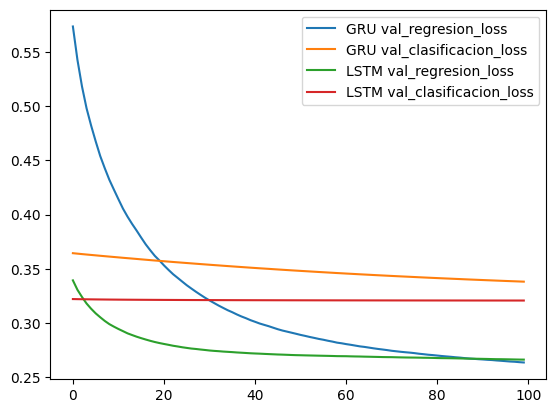

In [72]:
plt.plot(histGRU.history['val_regresion_loss'],label='GRU val_regresion_loss')
plt.plot(histGRU.history['val_clasificacion_loss'],label='GRU val_clasificacion_loss')
plt.plot(histLSTM.history['val_regresion_loss'],label='LSTM val_regresion_loss')
plt.plot(histLSTM.history['val_clasificacion_loss'],label='LSTM val_clasificacion_loss')
plt.legend();

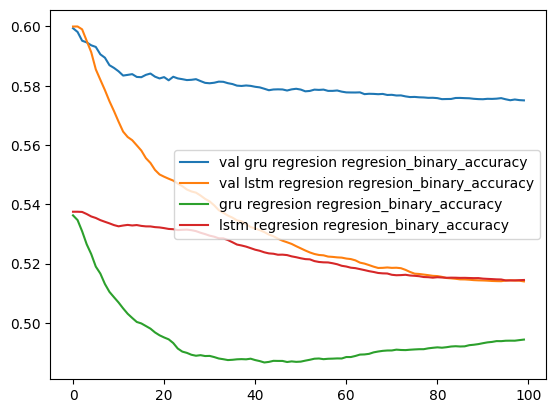

In [79]:
#plt.plot(histGRU.history['val_clasificacion_mean_absolute_error'],label='val gru clasificacion_mean_absolute_error')
plt.plot(histGRU.history['val_regresion_binary_accuracy'],label='val gru regresion regresion_binary_accuracy')
#plt.plot(histLSTM.history['val_clasificacion_mean_absolute_error'],label='val lstm clasificacion_mean_absolute_error')
plt.plot(histLSTM.history['val_regresion_binary_accuracy'],label='val lstm regresion regresion_binary_accuracy')
#plt.plot(histGRU.history['clasificacion_mean_absolute_error'],label='gru clasificacion_mean_absolute_error')
plt.plot(histGRU.history['regresion_binary_accuracy'],label='gru regresion regresion_binary_accuracy')
#plt.plot(histLSTM.history['clasificacion_mean_absolute_error'],label='lstm clasificacion_mean_absolute_error')
plt.plot(histLSTM.history['regresion_binary_acauracy'],label='lstm regresion regresion_binary_accuracy')
plt.legend();

### 3.3. LSTM y GRU anidados. Se requieren al menos dos capas.

In [41]:
input_layer = keras.Input(shape=(input_width,numero_caracteristicas))
x = layers.LSTM(256, return_sequences = True)(input_layer)
shared_layer = layers.GRU(64, return_sequences = True)(x)

output1 = layers.Dense(1, activation='softmax', name='clasificacion')(shared_layer)  # Clasificación
output2 = layers.Dense(1, activation='linear', name='regresion')(shared_layer)  # Regresión

modeloAnidado = keras.Model(inputs=input_layer, outputs=[output1, output2])

modeloAnidado.compile(loss=losses.MeanSquaredError(),
                  optimizer=optimizers.AdamW(learning_rate=0.01),
                  metrics=[metrics.MeanAbsoluteError(),metrics.BinaryAccuracy()])




In [42]:
histAnidado = modeloAnidado = modeloGRU.fit(x_train,
                {'clasificacion': y_train1, 'regresion': y_train2},
                callbacks = callback,
                epochs = 600, 
                validation_split = 0.05,
                batch_size=2048)

Epoch 1/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - clasificacion_loss: 0.4426 - clasificacion_mean_absolute_error: 0.6417 - loss: 0.7226 - regresion_binary_accuracy: 0.5473 - regresion_loss: 0.2801 - val_clasificacion_loss: 0.3270 - val_clasificacion_mean_absolute_error: 0.5270 - val_loss: 0.5910 - val_regresion_binary_accuracy: 0.5305 - val_regresion_loss: 0.2641
Epoch 2/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - clasificacion_loss: 0.4407 - clasificacion_mean_absolute_error: 0.6413 - loss: 0.7150 - regresion_binary_accuracy: 0.5464 - regresion_loss: 0.2743 - val_clasificacion_loss: 0.3250 - val_clasificacion_mean_absolute_error: 0.5270 - val_loss: 0.5858 - val_regresion_binary_accuracy: 0.5295 - val_regresion_loss: 0.2607
Epoch 3/600
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - clasificacion_loss: 0.4397 - clasificacion_mean_absolute_error: 0.6416 - loss: 0.7096 - regresion_binary_accuracy: 0.5457 - regresion_loss: 0.2699 - val_clasificacion_loss: 0.3231 - val_clasificacion_mean_abso

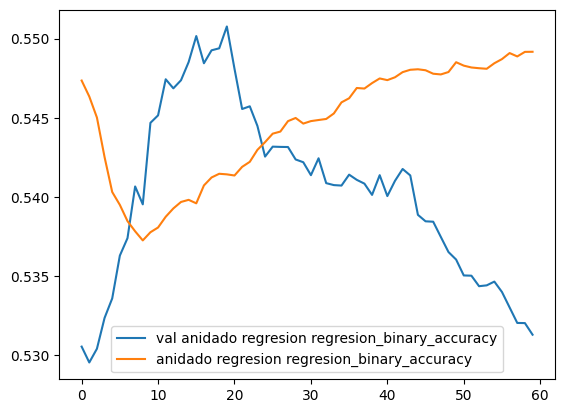

In [43]:
plt.plot(histAnidado.history['val_regresion_binary_accuracy'],label='val anidado regresion regresion_binary_accuracy')
plt.plot(histAnidado.history['regresion_binary_accuracy'],label='anidado regresion regresion_binary_accuracy')

plt.legend();

In [ ]:
test_loss = modeloAnidado.evaluate(x_test, y_test)

In [ ]:
prediccion = modeloAnidado.predict(x_test)

In [89]:
y_train2[0][0]

array([0.])

In [59]:
input_layer = keras.Input(shape=(input_width,numero_caracteristicas), name="input_layer")

# Capa GRU
gru_layer = layers.GRU(64, activation='relu', return_sequences=True, name="gru_layer_1")(input_layer)
gru_layer = layers.GRU(32, activation='relu', name="gru_layer_2")(gru_layer)

# Capa LSTM
lstm_layer = layers.LSTM(64, activation='relu', return_sequences=True, name="lstm_layer_1")(input_layer)
lstm_layer = layers.LSTM(32, activation='relu', name="lstm_layer_2")(lstm_layer)

# Concatenación de las salidas GRU y LSTM
merged = layers.concatenate([gru_layer, lstm_layer], name="concat_layer")

# Capa densa intermedia para procesar la combinación
dense_layer = layers.Dense(64, activation='relu', name="dense_layer")(merged)
dense_layer = layers.Dropout(0.3, name="dropout_layer")(dense_layer)

# Salida 1: Clasificación
classification_output = layers.Dense(1, activation='sigmoid', name="clasificacion")(dense_layer)

# Salida 2: Regresión
regression_output = layers.Dense(1, activation='linear', name="regresion")(dense_layer)

# Modelo con dos salidas
otroModelo = models.Model(inputs=input_layer, outputs=[classification_output, regression_output], name="gru_lstm_dual_output_model")


otroModelo.compile(loss=losses.MeanSquaredError(),
                  optimizer=optimizers.AdamW(learning_rate=0.01),
                  metrics=[metrics.MeanAbsoluteError(),metrics.BinaryAccuracy()])

In [ ]:
otroModelohist = otroModelo.fit(x_train,
                {'clasificacion': y_train1, 'regresion': y_train2},
                callbacks = callback,
                epochs = 600, 
                validation_split = 0.05,
                batch_size=2048)

Epoch 1/600
 4/10 ━━━━━━━━━━━━━━━━━━━━ 3:03 31s/step - clasificacion_loss: 0.4002 - clasificacion_mean_absolute_error: 0.6196 - loss: inf - regresion_binary_accuracy: 0.5284 - regresion_loss: inf      

### 3.4. Transformer (No es necesario entrenarlo, sólo prepararlo para su uso).

## 4. Evaluación del rendimiento del/los modelo/s frente a baselines.

### 4.1. Compara el rendimiento de tus modelos frente entre sí y con dos baselines sencillas (diseñados baselines similares para el problema binario):
 - Un modelo que prediga siempre el último valor de entrada recibido (6h antes del dato
a predecir).
 - Un modelo que prediga la media de los valores de entrada recibidos.

In [70]:
x_train[0][0], y_train2[0][0], x_train.shape

(array([ 1.1154    ,  1.12      ,  1.1154    ,  1.1182    , -0.82063064,
        -0.81122107, -0.93235984, -0.7778111 , -0.76981514,  0.8660254 ,
        -0.5       ,  0.24424105,  0.96971455]),
 array([0.]),
 (20848, 24, 13))

In [44]:
def baselineMedia(x, y):
    if np.mean(x) < x[-1]:
        return 1 == y
    return 0 == y 

def baselineMediana(x, y):
    if np.median(x) < x[-1]:
        return 1 == y
    return 0 == y 

def baselineUltimo(x, y):
    if x[-2] < x[-1]:
        return 1 == y
    return 0 == y 

accuracyBaselineMedia = (sum([baselineMedia(x_train[i][j],y_train2[i][j]) for i in range(x_train.shape[0]) for j in range(x_train.shape[1])])/(x_train.shape[0]*x_train.shape[1]))
accuracyBaselineMediana = float(sum([baselineMediana(x_train[i][j],y_train2[i][j]) for i in range(x_train.shape[0]) for j in range(x_train.shape[1])])/(x_train.shape[0]*x_train.shape[1]))
accuracyBaselineUltimo = float(sum([baselineUltimo(x_train[i][j],y_train2[i][j]) for i in range(x_train.shape[0]) for j in range(x_train.shape[1])])/(x_train.shape[0]*x_train.shape[1]))

print(f'Acuracy baseline media: {accuracyBaselineMedia}\nAcuracy baseline mediana: {accuracyBaselineMediana}\nAccuracy baseline último: {accuracyBaselineUltimo}.');

KeyboardInterrupt: 

### 4.2. Identifica sesgos en tu modelo. Para ello, analiza las distribuciones de entrenamiento y test y las predicciones/errores de entrenamiento/test. Si identificas algún problema, adapta tu pipeline para intentar solventarlo.

### 4.3. Busca dar respuesta a las preguntas, ¿por cuántos céntimos de dólar falla cada modelo? ¿Cuánto puedo esperar ganar con mi modelo durante el periodo de test, haciendo las operaciones de 1$?

In [ ]:
def calcular_ganancias(sliding_windows_test, modelos):
    ganancias = {}
    for nombre, modelos_conj in modelos.items(): #por cada modelo
        # print(nombre)
        # print(modelos_conj)
        for w, modelo in modelos_conj.items(): #por cada ventana del modelo 
            print(f"\nCalculando ganancias para modelo {nombre} con ventana de {w} horas")
            x_test = sliding_windows_test[w]["x"].astype(np.float32) #se toma la ventana de test
            y_test = sliding_windows_test[w]["y"][:, -1, 0].astype(np.float32) #se toma la etiqueta de la ventana de test

            y_pred = modelo.predict(x_test)[:, -1] #se hace la predicción del modelo

            # Ganancias por operaciones
            ganancias_modelo = []
            for real, pred in zip(y_test, y_pred): #por cada valor real y predicho
                if pred >= 0.5:  # Modelo predice que subirá
                    ganancias_modelo.append(real - x_test[0, -1, 1]) #se calcula la ganancia
                else:  # Modelo predice que bajará
                    ganancias_modelo.append(x_test[0, -1, 1] - real) #0 es la primera ventana, -1 es la última hora, 1 es el precio de inicio

            ganancias[f"{nombre}_w{w}"] = np.sum(ganancias_modelo)

    return ganancias

# Calcular ganancias esperadas

modelos_complejos = {
    "LSTM": lstm_models,
    "GRU": gru_models,
    "LSTM_GRU": lstm_gru_models,
    "LSTM_GRU_regularizado": lstm_gru_models_regularizado
}

ganancias = calcular_ganancias(sw_test, [otroModelo])

print("Ganancias esperadas por modelo:", ganancias)